# "Прогнозирование температуры плавления стали"

**Промышленность — задача проекта:**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру.

**Описание этапа обработки:**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных:**

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время)

Во всех файлах столбец **key** содержит номер партии. В файлах может быть несколько строк с одинаковым значением **key**: они соответствуют разным итерациям обработки.

In [1]:
!pip install shap

     |████████████████████████████████| 572 kB 1.2 MB/s eta 0:00:01


In [2]:
!pip install pyod

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
sns.set(style="darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from pyod.models.knn import KNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV
import math
import warnings
import shap
warnings.filterwarnings('ignore')

RS = 20623

In [4]:
df_arc = pd.read_csv('/datasets/data_arc_new.csv')
df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
df_gas = pd.read_csv('/datasets/data_gas_new.csv')
df_temp = pd.read_csv('/datasets/data_temp_new.csv')
df_wire = pd.read_csv('/datasets/data_wire_new.csv')
df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

## Данные об электродах

In [5]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [7]:
df_arc['key'].duplicated().sum()

11662

In [8]:
df_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

In [9]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [10]:
df_arc[df_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [11]:
df_arc['Реактивная мощность'].median()

0.44163949999999996

In [12]:
df_arc['Активная мощность'].median()

0.5995865

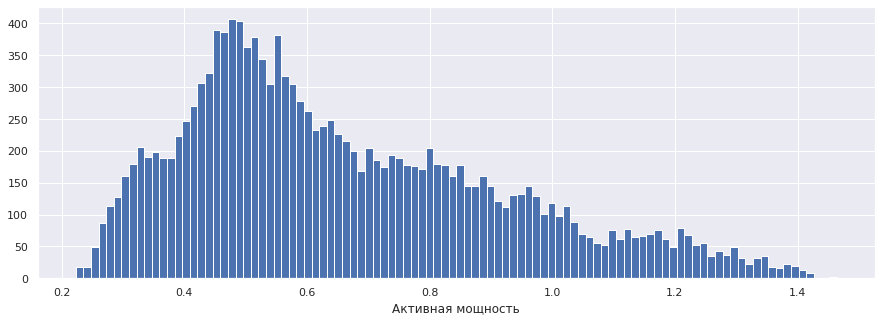

In [13]:
plt.figure(figsize=(15,5))
df_arc['Активная мощность'].hist(bins=100,
                 alpha=1)


plt.xlabel('Активная мощность')
plt.show()

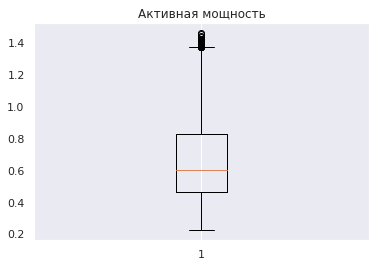

In [14]:
plt.boxplot(df_arc['Активная мощность'])
plt.grid(axis='y')
plt.title('Активная мощность')
plt.show()

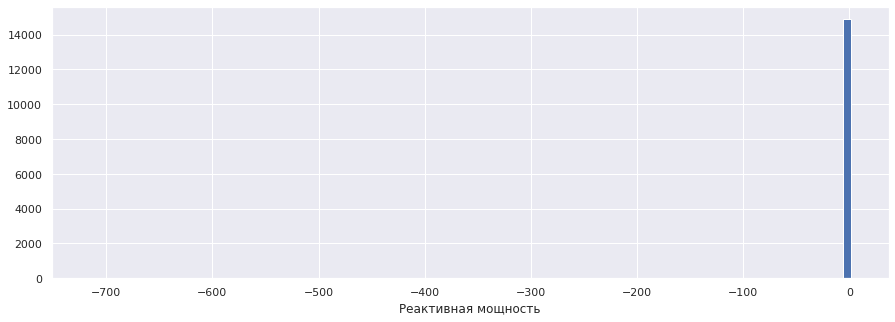

In [15]:
sns.set(style="darkgrid")

plt.figure(figsize=(15,5))
df_arc['Реактивная мощность'].hist(bins=100,
                 alpha=1)


plt.xlabel('Реактивная мощность')
plt.show()

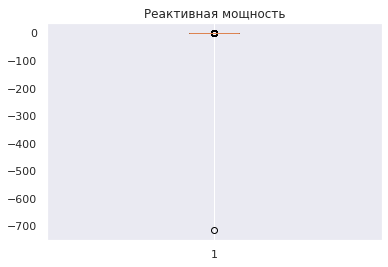

In [16]:
plt.boxplot(df_arc['Реактивная мощность'])
plt.grid(axis='y')
plt.title('Реактивная мощность')
plt.show()

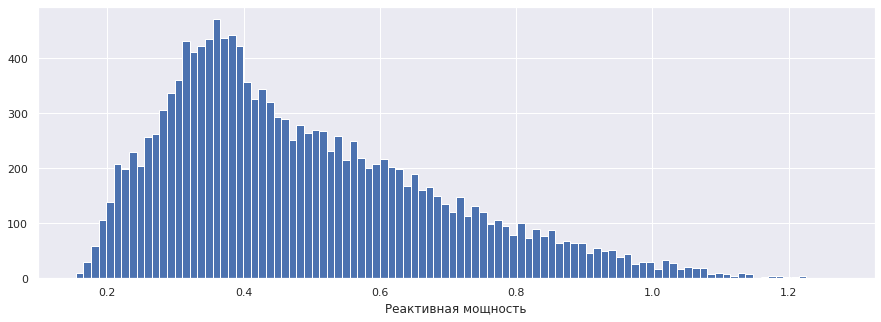

In [17]:




plt.figure(figsize=(15,5))
df_arc[df_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100,
                 alpha=1)


plt.xlabel('Реактивная мощность')
plt.show()

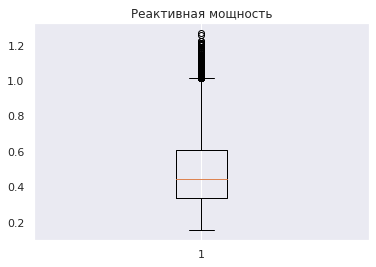

In [18]:
plt.boxplot(df_arc[df_arc['Реактивная мощность'] > 0]['Реактивная мощность'])
plt.grid(axis='y')
plt.title('Реактивная мощность')
plt.show()

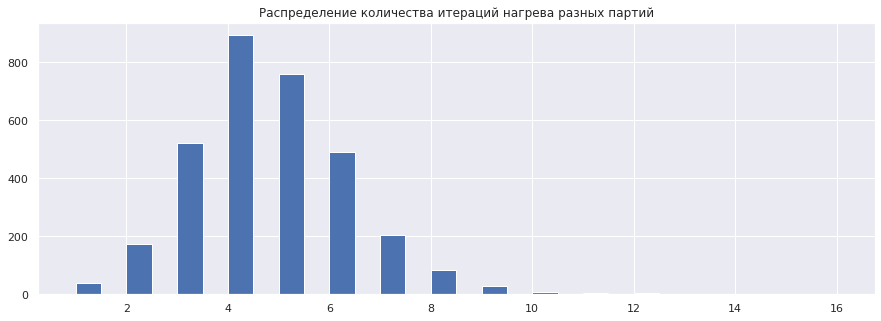

In [19]:
plt.figure(figsize=(15,5))
plt.hist((list(df_arc['key'].value_counts())), bins=30)
plt.title('Распределение количества итераций нагрева разных партий')
plt.show()



In [20]:
print('Корреляция Активной и Реактивной мощности', 
      df_arc['Активная мощность'].corr(df_arc['Реактивная мощность']))

Корреляция Активной и Реактивной мощности 0.03116414860619976


In [21]:
#df_arc =df_arc[df_arc['Реактивная мощность'] >= 0]

In [22]:
#print('Корреляция Активной и Реактивной мощности', 
      #df_arc['Активная мощность'].corr(df_arc['Реактивная мощность']))

### Вывод:

- датасет имеет **14876** строки и **5** колонок 

- присутвуют столбцы с названием на русском языке

- столбцы **Начало нагрева дугой**	**Конец нагрева дугой** имеют тип данных object

- гистрограмма и боксплот **Активной мощности** говорит нам что распределение скошено вправо 

- Вектор **Реактивная мощность** имеет аномальное отрицательное значение 
(без аномального значения гистрограмма и боксплот Реактивной мощности говорит нам что распределение скошено вправо)

- значение корреляции **Активной** и **Реактивной мощности** показывает практически нулевую зависимость (значение корреляции должно измениться после удаления аномалии в Реактивной мощности)

- кол-во итераций от **1** до **16**, чаще всего требуется **3-6** итераций 

**Что нужно сделать:**

- переименовать названия веткоров на англ.

- поменять тип данных для на **datetime** для векторов  **'Начало нагрева дугой'**, **'Конец нагрева дугой'**

- удалить аномальное значение в векторе **'Реактивная мощность'**

- если после удаления аномального значения появится корреляция - создать вектор **'Полная мощность'**

## Данные о подаче сыпучих материалов 

### Объём

In [23]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [24]:
df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [25]:
df_bulk.isnull().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [26]:
df_bulk.isnull().sum().sum()

35776

In [27]:
df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


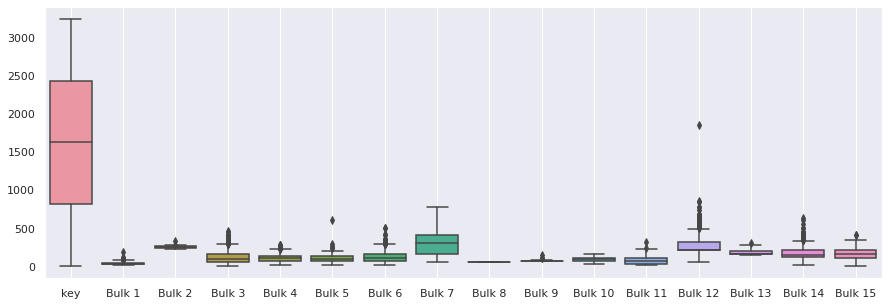

In [28]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_bulk)
plt.grid()

In [29]:
df_bulk.duplicated().sum()

0

In [30]:
df_bulk['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

In [31]:
len(df_bulk['key'].unique())

3129

### Время

In [32]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [33]:
df_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


In [34]:
df_bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [35]:
df_bulk_time.duplicated().sum()

0

In [36]:
df_bulk_time.isnull().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [37]:
df_bulk_time.isnull().sum().sum()

35776

In [38]:
df_bulk['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

In [39]:
len(df_bulk_time['key'].unique())

3129

### Вывод:

- датасеты имею по **3129** строк и **16** колонок



**Объём:**

- имеются пропупски **35776**, вероятно особенности тех. процесса и производства 

- боксплот показывает у **'Bulk 5'** и **'Bulk 12'** имеются аномалии

- дубликаты отсутствуют 

- **'key'** уникален для каждой строки 


**Время:**

- имеются пропупски **35776**

- дубликаты отсутствуют

- **'key'** уникален для каждой строки 



**Что нужно сделать:**

- поменять тип данных у векторов **'Bulk'** на **int** в датасете **'df_bulk'**


- заменить пропуски на ноль в **'df_bulk'** и  **'df_bulk_time'**


- заменить тип данных c **object** на **datetime** в **df_bulk_time**

## Данные о продувке сплава газом

In [40]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [41]:
df_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [42]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [43]:
df_gas.duplicated().sum()

0

In [44]:
len(df_gas['key'].unique())

3239

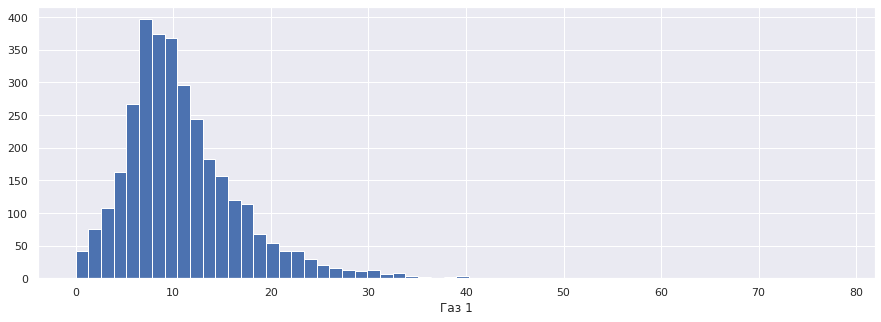

In [45]:
plt.figure(figsize=(15,5))
df_gas['Газ 1'].hist(bins=60,
                 alpha=1)


plt.xlabel('Газ 1')
plt.show()

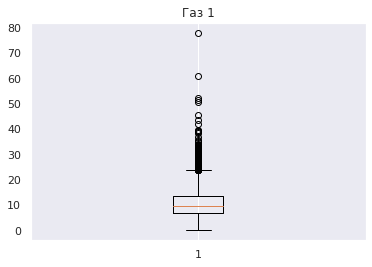

In [46]:
plt.boxplot(df_gas['Газ 1'])
plt.grid(axis='y')
plt.title('Газ 1')
plt.show()

### Вывод:

- датасет имеет **3239** строки и **2** колонки 

- дубликаты отсутствуют 

- данные распределнны вправо 

- **'key'** уникален для каждой строки

- колонка **'Газ 1'** на русском языке 



**Что сделать:**

- переименовать колонку 



## Результаты измерения температуры

In [47]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [48]:
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [49]:
df_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [50]:
df_temp.median()

key            1618.0
Температура    1590.0
dtype: float64

In [51]:
df_temp.duplicated().sum()

0

In [52]:
df_temp.isnull().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

In [53]:
len(df_temp['key'].unique())

3216

In [54]:
df_temp['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

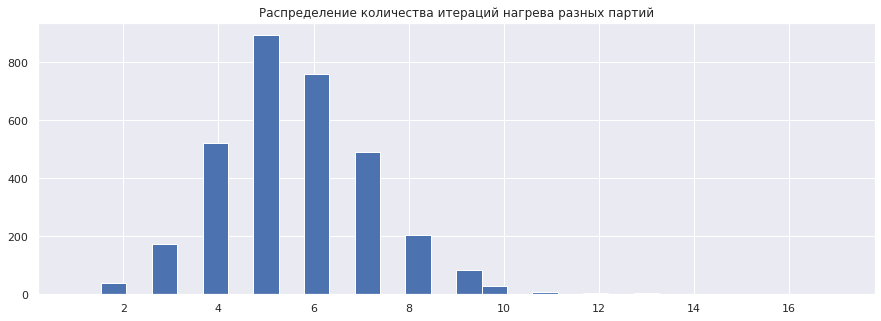

In [55]:
plt.figure(figsize=(15,5))
plt.hist((list(df_temp['key'].value_counts())), bins=30)
plt.title('Распределение количества итераций нагрева разных партий')
plt.show()

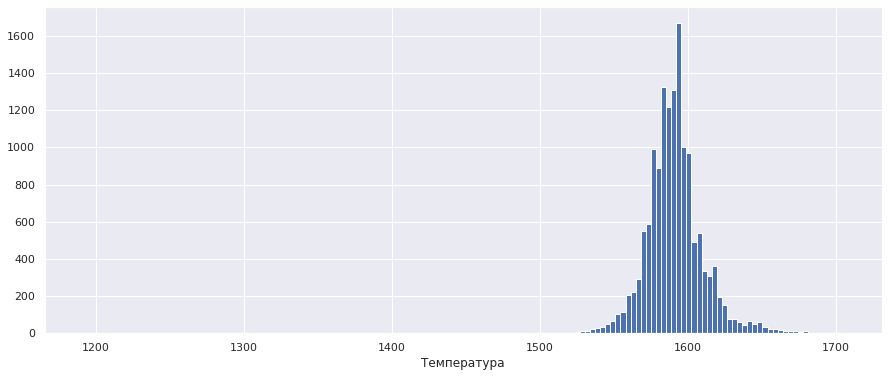

In [56]:
plt.figure(figsize=(15,6))
df_temp['Температура'].hist(bins=150,
                 alpha=1)


plt.xlabel('Температура')
plt.show()

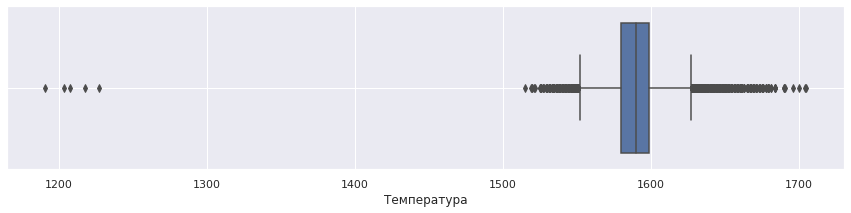

In [57]:
plt.figure(figsize=(15,3))
sns.boxplot(df_temp['Температура'])
plt.grid(axis='y')
plt.show()

### Вывод:

- датасет имеет **18092** строк и **3** колонки 

- вектрок **'Тепература'** написан на русском 

- имеется **3427** пропуска, отсутствуют замеры последней температуры (целевой признак) 

- данные распределны симметрично

- кол-во итераций от **1** до **17**, чаще всего требуется **4-7** итераций  

- имеются выбросы 



**Что делать:**

- удалить пропуски 

- переминовать **'Тепература'** на англ. язык

## Данные о проволочных материалах 

### Объём

In [58]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [59]:
df_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [61]:
df_wire.median()

key       1619.000000
Wire 1     100.158234
Wire 2      40.142956
Wire 3     235.194977
Wire 4      45.234282
Wire 5      15.132000
Wire 6      42.076324
Wire 7       9.017009
Wire 8      46.279999
Wire 9      30.066399
dtype: float64

In [62]:
df_wire.duplicated().sum()

0

In [63]:
df_wire.isnull().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [64]:
df_wire.isnull().sum().sum()

23385

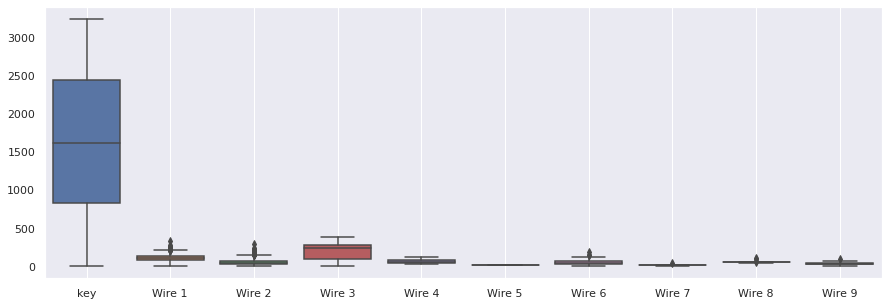

In [65]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_wire)
plt.grid()

### Время

In [66]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [67]:
df_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
df_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [69]:
df_wire_time.duplicated().sum()

0

In [70]:
df_wire_time.isnull().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [71]:
df_wire_time.isnull().sum().sum()

23385

In [72]:
df_wire_time['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

In [73]:
len(df_wire_time['key'].unique())

3081

### Вывод

- датасеты имею по **3081** строк и **10** колонок



**Объём:**

- имеются пропупски **23385**, вероятно особенности тех. процесса и производства 

- аномалии не выявлены 

- дубликаты отсутствуют 

- **'key'** уникален для каждой строки 


**Время:**

- имеются пропупски **23385**

- дубликаты отсутствуют

- **'key'** уникален для каждой строки 



**Что нужно сделать:**

- привести название колонок в строчный вид и убрать пробелы 


- заменить пропуски на ноль в **'df_wire'** и  **'df_wire_time'**


- заменить тип данных c **object** на **datetime** в **df_wire_time**

## План работы 

### Провести предобработку данных

**df_arc:**

- переименовать названия веткоров на англ.

- поменять тип данных для на **datetime** для векторов **'Начало нагрева дугой'**, **'Конец нагрева дугой'**

- удалить аномальное значение в векторе **'Реактивная мощность'**




**df_bulk(df_bulk_time):**

- поменять тип данных у векторов **'Bulk'** на **int** в датасете **'df_bulk'**


- заменить пропуски на ноль в **'df_bulk'** и  **'df_bulk_time'**


- заменить тип данных c **object** на **datetime** в **df_bulk_time**



**df_gas:**

- переименовать колонку 



**df_temp(df_temp_time):**

- удалить пропуски 

- переминовать **'Тепература'** на англ. язык


**df_wire(df_wire_time):**

- привести название колонок в строчный вид и убрать пробелы

- заменить пропуски на ноль в **'df_wire'** и **'df_wire_time'**

- заменить тип данных c **object** на **datetime** в **df_wire_time**

_______________


1. Создать признаки:

- cоздать таблицу с начальным и конечным замером температуры

- cоздать таблицу с продолжительностью нагрева в минутах

- cоздать таблицу с полной мощностью 

- сгруппировать таблицы по индексу **'key'**

- провести оценку важности признаков 

- проверить на корреляцию 

2. Cоздать выборки 

- разделить на обучающую и тестовую 

- провести масштабирование 

3. Модели

- обучить модель и провести оценку кроссвалидацией

- протестировать лучшую модель 

- пишем вывод о проделанной работе 

## Предобработка данных

In [74]:
df_arc.columns = ['key', 'arc_start_time','arc_end_time', 'active_power', 'reactive_power']
df_gas.columns = ['key', 'gas_1']
df_temp.columns = ['key', 'time', 'temp']
df_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
df_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

### df_arc

In [75]:
df_arc['arc_start_time'] = pd.to_datetime(df_arc['arc_start_time'], format='%Y-%m-%dT%H:%M:%S')
df_arc['arc_end_time'] = pd.to_datetime(df_arc['arc_end_time'], format='%Y-%m-%dT%H:%M:%S')

#### Удалим аномальное значение в векторе 'Реактивная мощность' 

In [76]:
df_arc.drop(df_arc[df_arc['reactive_power'] <= 0].index, inplace=True)

In [77]:
df_arc

,key,arc_start_time,arc_end_time,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


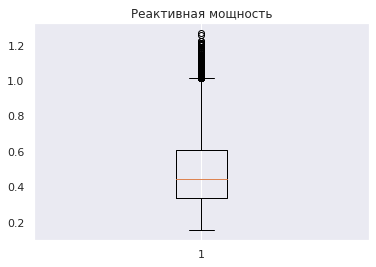

In [78]:
plt.boxplot(df_arc['reactive_power'])
plt.grid(axis='y')
plt.title('Реактивная мощность')
plt.show()

In [79]:
print('Корреляция Активной и Реактивной мощности', 
      df_arc['active_power'].corr(df_arc['reactive_power']))

Корреляция Активной и Реактивной мощности 0.9663734456187295


**Корреляция изменилась**

#### Создадим таблицу с продолжительностью нагрева в минутах (heating_duration)  и полной мощностью (full_power)

In [80]:
df_arc_fp = df_arc.copy()

In [81]:
df_arc_fp['heating_duration'] = (df_arc_fp['arc_end_time'] - df_arc_fp['arc_start_time']) / pd.Timedelta(minutes=1)

In [82]:
df_arc_fp['full_power'] = np.sqrt(df_arc['active_power']**2 + df_arc['reactive_power']**2)

In [83]:
df_arc_fp = df_arc_fp.groupby(by = 'key', as_index = False).sum()


In [84]:
df_arc_fp

,key,active_power,reactive_power,heating_duration,full_power
0,1,3.036730,2.142821,18.300000,3.718736
1,2,2.139408,1.453357,13.516667,2.588349
2,3,4.063641,2.937457,10.916667,5.019223
3,4,2.706489,2.056992,12.350000,3.400038
4,5,2.252950,1.687991,14.483333,2.816980
...,...,...,...,...,...
3209,3237,2.541872,2.025417,15.150000,3.250657
3210,3238,1.374821,1.038103,9.100000,1.723937
3211,3239,4.848005,3.541541,20.266667,6.014480
3212,3240,3.317679,2.373552,13.983333,4.082920


In [85]:
df_arc_fp = df_arc_fp.drop(columns = ['active_power','reactive_power'], axis = 1)

In [86]:
df_arc_fp

,key,heating_duration,full_power
0,1,18.300000,3.718736
1,2,13.516667,2.588349
2,3,10.916667,5.019223
3,4,12.350000,3.400038
4,5,14.483333,2.816980
...,...,...,...
3209,3237,15.150000,3.250657
3210,3238,9.100000,1.723937
3211,3239,20.266667,6.014480
3212,3240,13.983333,4.082920


### df_temp

#### Удалим выбросы ('temp' < 1400)

In [87]:
df_temp

,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [88]:
df_temp.drop(df_temp[df_temp['temp'] < 1400].index, inplace=True)

In [89]:
df_temp

,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


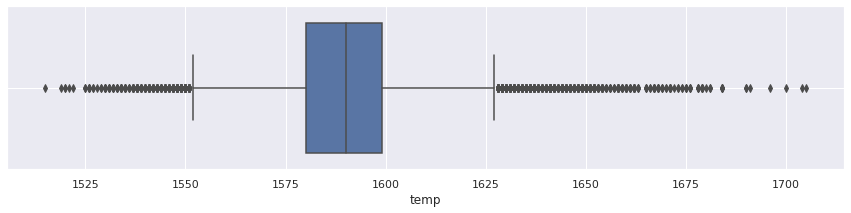

In [90]:
plt.figure(figsize=(15,3))
sns.boxplot(df_temp['temp'])
plt.grid(axis='y')
plt.show()

#### Cоздадим таблицу с начальным и конечным замером температуры

In [91]:
df_temp_v2 = df_temp.copy()

In [92]:
df_temp_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18087 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     18087 non-null  int64  
 1   time    18087 non-null  object 
 2   temp    14660 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 565.2+ KB


In [93]:
df_temp_v2

,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [94]:
df_temp_v2.isnull().sum()

key        0
time       0
temp    3427
dtype: int64

In [95]:
df_temp_v2 = df_temp_v2.dropna(subset=['temp']).reset_index(drop=True)
df_temp_v2 = df_temp_v2.sort_values(by=['time'])

In [96]:
count = df_temp_v2.groupby(by = 'key', as_index=False).count()
one = count[count['time']== 1]['key'].tolist()
df_temp_v2 = df_temp_v2.query('key not in @one')

In [97]:
df_temp_v2

,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13917,2499,2019-08-10 13:33:21,1569.0
13918,2499,2019-08-10 13:41:34,1604.0
13919,2499,2019-08-10 13:46:28,1593.0
13920,2499,2019-08-10 13:54:56,1588.0


In [98]:
df_temp_v2 = df_temp_v2.groupby(by = 'key').agg(['first', 'last']).reset_index()
df_temp_v2.columns = df_temp_v2.columns.droplevel()
df_temp_v2.columns = ['key', 's', 'e', 'start_temp', 'end_temp']
df_temp_v2 = df_temp_v2[['key', 'start_temp', 'end_temp']]

In [99]:
df_temp_v2

,key,start_temp,end_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


### Итоговая таблица 

In [100]:
df_model = (df_temp_v2.merge(df_arc_fp, how='inner', on = 'key') 
        .merge(df_wire, how='inner', on = 'key')
        .merge(df_bulk, how='inner', on = 'key')
        .merge(df_gas, how='inner', on = 'key'))

In [101]:
df_model.isna().sum()

key                    0
start_temp             0
end_temp               0
heating_duration       0
full_power             0
wire_1                23
wire_2              1518
wire_3              2290
wire_4              2317
wire_5              2329
wire_6              2284
wire_7              2325
wire_8              2316
wire_9              2305
bulk_1              2130
bulk_2              2316
bulk_3              1369
bulk_4              1517
bulk_5              2276
bulk_6              1891
bulk_7              2316
bulk_8              2328
bulk_9              2316
bulk_10             2186
bulk_11             2199
bulk_12              517
bulk_13             2315
bulk_14              261
bulk_15              630
gas_1                  0
dtype: int64

In [102]:
df_model = df_model.fillna(0)

In [103]:
df_model

,key,start_temp,end_temp,heating_duration,full_power,wire_1,wire_2,wire_3,wire_4,wire_5,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1
0,1,1571.0,1613.0,18.300000,3.718736,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,13.516667,2.588349,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,10.916667,5.019223,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,12.350000,3.400038,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,14.483333,2.816980,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,12.050000,3.868721,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2325,2496,1554.0,1591.0,15.666667,5.070316,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2326,2497,1571.0,1589.0,9.483333,4.360918,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2327,2498,1591.0,1594.0,12.500000,3.909917,118.110717,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


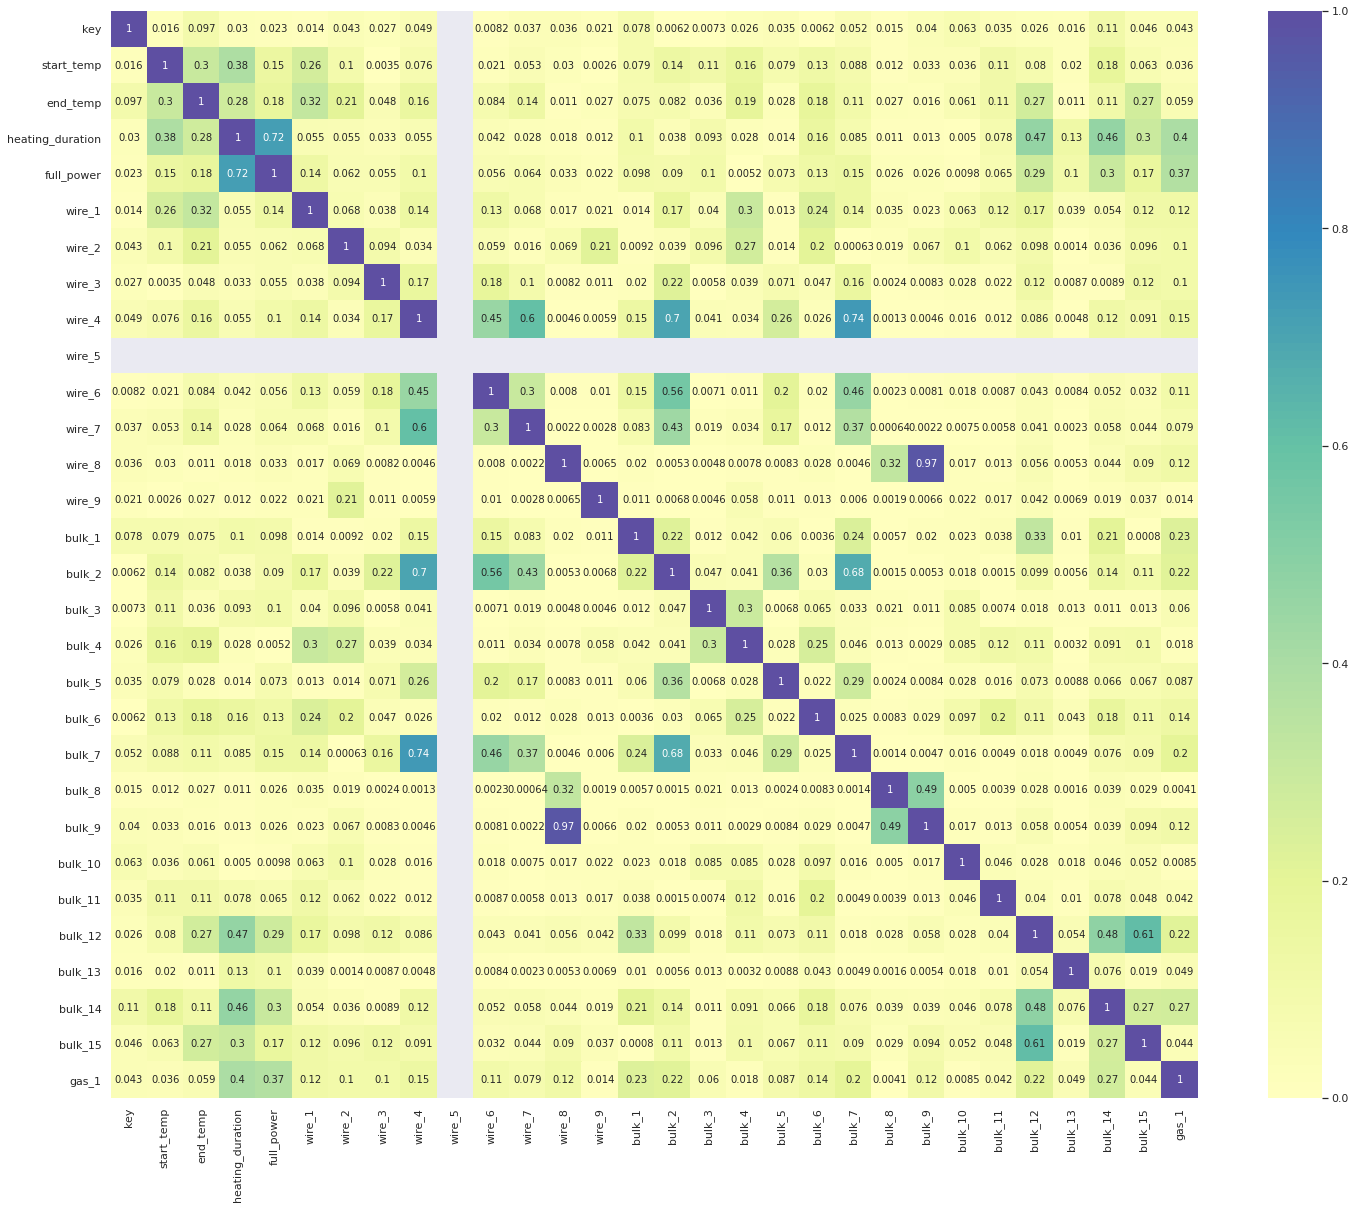

In [104]:
corr = abs(df_model.corr())

f, ax = plt.subplots(figsize=(25, 20))

font = {'size': 10}
plt.rc('font', **font)

cmap = 'Spectral'

ax = sns.heatmap(
    corr,          
    cmap=cmap,     
    annot=True,    
    vmax=1,       
    vmin=0,      
    center=0,      
    square=True,   
    linewidths=0, 
    xticklabels=True,
    yticklabels=True
)

In [105]:
df_model = df_model.drop(['bulk_9','wire_5'], axis=1)


In [106]:
df_model = df_model.set_index('key')


In [107]:
df_model

,start_temp,end_temp,heating_duration,full_power,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,...,bulk_6,bulk_7,bulk_8,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,18.300000,3.718736,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
2,1581.0,1602.0,13.516667,2.588349,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
3,1596.0,1599.0,10.916667,5.019223,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
4,1601.0,1625.0,12.350000,3.400038,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
5,1576.0,1602.0,14.483333,2.816980,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,12.050000,3.868721,89.150879,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2496,1554.0,1591.0,15.666667,5.070316,114.179527,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2497,1571.0,1589.0,9.483333,4.360918,94.086723,9.04800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699


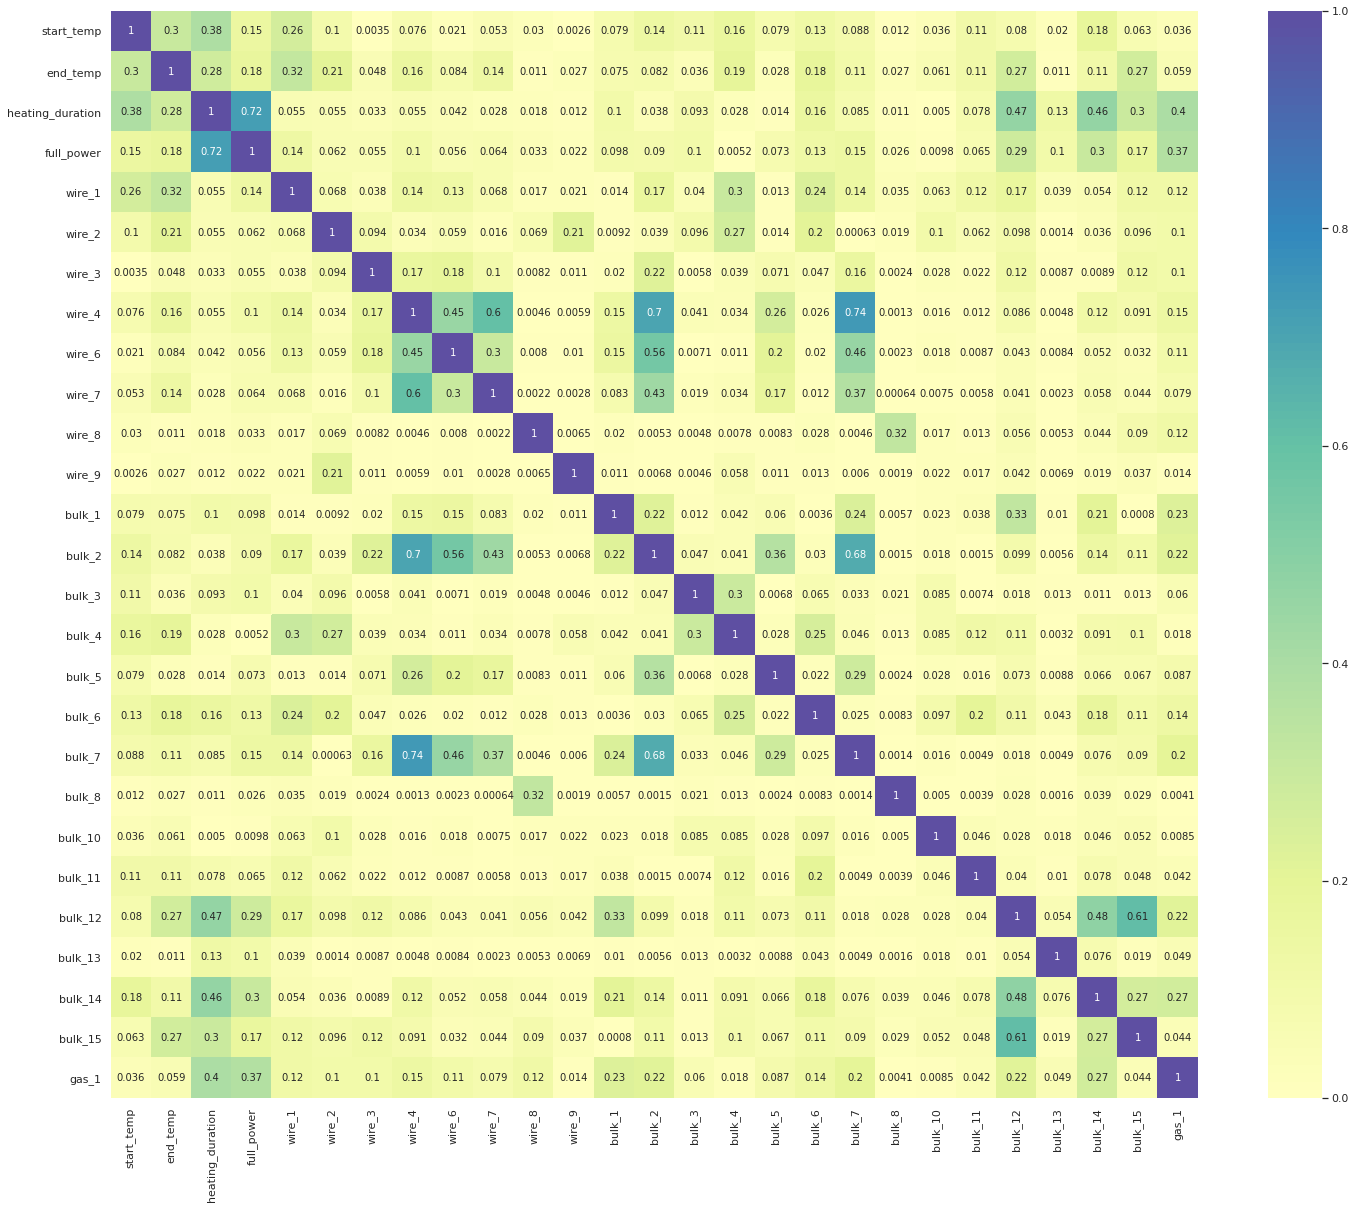

In [108]:
corr = abs(df_model.corr())

f, ax = plt.subplots(figsize=(25, 20))

font = {'size': 10}
plt.rc('font', **font)

cmap = 'Spectral'

ax = sns.heatmap(
    corr,          
    cmap=cmap,     
    annot=True,    
    vmax=1,       
    vmin=0,      
    center=0,      
    square=True,   
    linewidths=0, 
    xticklabels=True,
    yticklabels=True
)

### Вывод

1. Переменованны название векторов на англ. яз.


2. Удалены супер выбросы: 

   - реактивная темература < 0
   - темература < 1400
   
   
3. Удалены объекты моделирования (ковши) у которых нет целевой (последнего измерения)   


4. Удалены объекты моделирования (ковши) с одним замером температуры


5. Созданы таблицы:
  -  продолжительность нагрева в минутах (heating_duration) 
  -  полная мощность (full_power)
  -  с начальным и конечным замером температуры
  
  
6. Пропуски заменены на ноль  


7. Создана итоговая таблица для модели (df_model)


8. Мультиколлинеарность:

  - удален пустой вектор **'Wire'**
  - удален вектор **'bulk_9'** из-за корреляции >0.9

## Выборки

In [109]:
train, test = train_test_split(df_model, test_size=0.25, random_state = RS)

In [110]:
train_features = train.drop(['end_temp'], axis =1)
train_target = train['end_temp']

test_features = test.drop(['end_temp'], axis =1)
test_target = test['end_temp']



In [111]:
scaler= StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

#### Вывод 

- целевой признак **'end_temp'** - конечная температура 


- датасет разбит на теренировочную и тестовую выборки  (размер тестовой 0.25)


- данные масштабированы 

## Модели 

#### LinearRegression

In [112]:
%%time

regressor = LinearRegression()
print('# Train for mean_absolute_error')
print()
cv_MAE_LR = (cross_val_score(regressor, 
                             train_features, 
                             train_target, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of LinearRegression =', cv_MAE_LR)

# Train for mean_absolute_error

Mean MAE from CV of LinearRegression = 6.784182333511501
CPU times: user 39.8 ms, sys: 56.5 ms, total: 96.3 ms
Wall time: 60.8 ms


####  RandomForestRegressor

In [113]:
%%time

model_rf = RandomForestRegressor()

param_grid_rf = {
    'n_estimators': [10,50],
    'max_depth': [10,50],
    'random_state' : [RS]
}


gs_rf = GridSearchCV(
    estimator = model_rf, 
    param_grid=param_grid_rf, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1,
    cv=5
)

gs_rf.fit(train_features, train_target)

best_params_rf= gs_rf.best_params_

display(gs_rf.best_score_ * -1)
display(gs_rf.best_params_)

6.258149414171253

{'max_depth': 10, 'n_estimators': 50, 'random_state': 20623}

CPU times: user 4.92 s, sys: 16.2 ms, total: 4.93 s
Wall time: 4.95 s


#### LGBMRegressor

In [114]:
%%time

model_lgbm = LGBMRegressor()

param_grid_lgbm = {
                  'boosting_type': ['gbdt'],
                  'n_estimators': [10,50],
                   'max_depth': [10,50],
                  'random_state' : [RS]
                  }

gr_lgbm = GridSearchCV(estimator = model_lgbm,
                          param_grid = param_grid_lgbm,
                          scoring = 'neg_mean_absolute_error',
                          cv=5)

gr_lgbm.fit(train_features, train_target)   

display(gr_lgbm.best_params_)
display(gr_lgbm.best_score_*-1)

{'boosting_type': 'gbdt',
 'max_depth': 10,
 'n_estimators': 50,
 'random_state': 20623}

6.344969774808329

CPU times: user 7.87 s, sys: 59.8 ms, total: 7.93 s
Wall time: 8.05 s


In [115]:
sravnenie = [[6.784182333511501],
        [6.258149414171253],
        [6.344969774808329]]
             
model = ["LinearRegression", "RandomForestRegressor", "LGBMRegressor"]

pd.DataFrame(data=sravnenie, index=model, columns=["Train MAE"])

,Train MAE
LinearRegression,6.784182
RandomForestRegressor,6.258149
LGBMRegressor,6.344970


#### Тест 

In [116]:
model = RandomForestRegressor()
model.set_params(**best_params_rf)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
test_MAE_LGBMR = mean_absolute_error(target_predict, test_target)
print('MAE RandomForestRegressor =', test_MAE_LGBMR)

MAE RandomForestRegressor = 6.137917614166785


In [117]:
index = ['RandomForestRegressor']

metric = {
        'Test MAE':[6.137917614166785
                  ]}

sravnenie = pd.DataFrame(data=metric, index=index)
sravnenie['Выполнение задачи'] = sravnenie['Test MAE'] <= 6.8
sravnenie

,Test MAE,Выполнение задачи
RandomForestRegressor,6.137918,True


#### Важность признаков 

In [118]:
base_rf_model = RandomForestRegressor(**best_params_rf)
base_rf_model.fit(train_features, train_target);

In [119]:
explainer = shap.TreeExplainer(base_rf_model)  
shap_values = explainer.shap_values(train_features)  

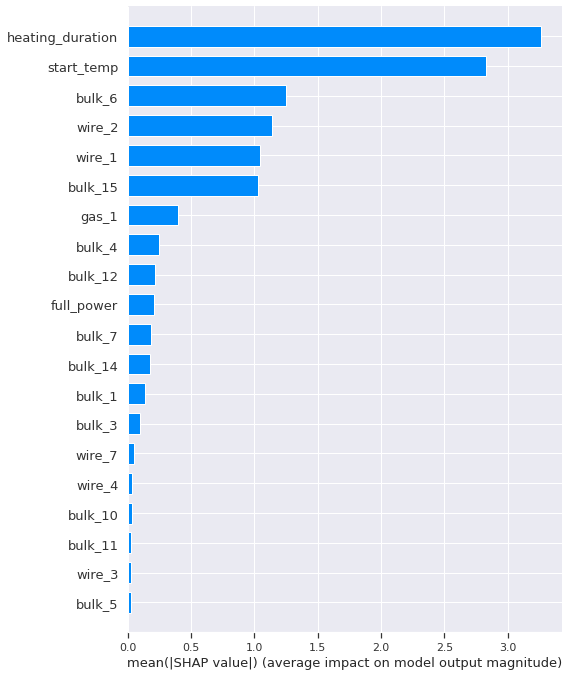

In [120]:
shap.summary_plot(shap_values, train.drop(['end_temp'], axis =1), plot_type='bar')

### Вывод 

 1. Были обучены след. модели путем кроссвалидации:
    - **LinearRegression**
    - **RandomForestRegressor**
    - **LGBMRegressor**
    
Все модели показали отличный результат **МАЕ** < 6.8

Наилучшей моделью оказалась **RandomForestRegressor**:
- **MAE** 6.137917614166785
- **max_depth** 10
- **'n_estimators**' 50


2. Важность признаков

Наиболее важными признаками для предсказания температуры выпуска стали из ковша являются:

- **heating_duration** (продолжительностью нагрева)

- **temp_first** (начальная температура)

- подача сыпучих материалов (объем) (**bulk_6**)

- проволочные материалах (объём) (**wire_2**)

Признаки некоторых добавок имеют почти нулевую значимость

## Отчёт

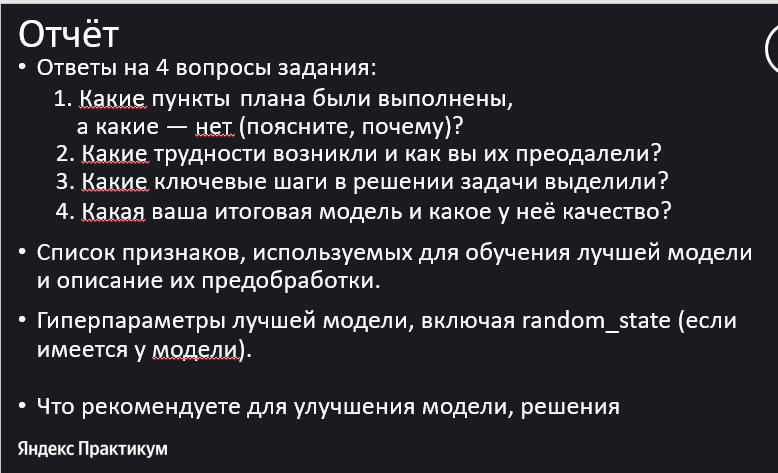

**1.) Какие пункты плана были выполнены,
а какие — нет (поясните, почему)?**

- все пункты плана далось выполнить  

**2.) Какие трудности возникли и как вы их преодалели?**

Проблема: 
- не удавалось получить нужную метрику


Решение:
- создание нового признака продолжительностью нагрева в минутах **(heating_duration)**

**3.) Какие ключевые шаги в решении задачи выделили?**

- изучение и понимание тз
- анализ данных 
- прдеобработка и создание датасета для построения моделей 

**4.) Какая ваша итоговая модель и какое у неё качество?**
- Итоговой модель: **RandomForestRegressor** 

- **MAE** 6.137917614166785

**5.) Список признаков, используемых для обучения лучшей модели
и описание их предобработки.**

Все признаки были объединены в итоговую таблицу по **key** с помощью **'inner'**

 1. **start temp** (старотовая температура)
 - удалены супер выбросы темература **< 1400**
 - удалены пропущенные значения 
 - сортировка по времени 
 - удаление ковшей **(key)** где имеется только один замер температуры 
 - разделение на начальную и итоговую температару 
    
2. **heating_duration** (продолжительность нагрева)
- удален супер выборс реактивная темература **< 0**
- создание признака heating_duration (разница конечной и стартовой температуры) 

3. **full_power** (полная мощность)
- удален супер выборс реактивная темература **< 0**
- получение полной мощности **(full_power)** по формуле $$ \sqrt{P^2+Q^2} $$ где: 
- **P** - active_power 
- **Q** - reactive_power


- группировка и суммирование по **key**

4. **gas_1** (данные о продувке сплава газом)
- пропущенные значения заменены на ноль

5. **bukl (объём)** (данные о подаче сыпучих материалов)
- пропущенные значения заменены на ноль

6. **wire (объём)** (данные о проволочных материалах)
- пропущенные значения заменены на ноль



**6.) Гиперпараметры лучшей модели, включая random_state (если
имеется у модели).**

- **'max_depth':** 10
- **'n_estimators':** 50
- **RS:** 20623

**7.) Что рекомендуете для улучшения модели, решения**

Предполагаю боллее тщательный подброр параметров (в т.ч увелечение подбираемых параметров) и использования например метода ансамблирования Бэггинг (bagging) улучшило бы качество модели.